# Non stationary Ornstein Uhlenbeck in 1D (Fokker-Planck Equation)

We want to estimate the solution $u(t,x)$ of
$$
-\frac{\partial}{\partial x}\left[(\alpha(\mu - x))u(t,x)\right]+
\frac{\partial^2}{\partial x^2}\left[\frac{\sigma^2}{2}u(t,x)\right] =
\frac{\partial}{\partial t}u(t,x)
 $$
 This PDE describes the probability density function of the Orstein-Uhlenbeck process defined as

$$
    \frac{{\mathrm d}}{{\mathrm d}t}X_t=(\alpha(\mu - X_t)) + \sigma\Gamma
$$
where $\Gamma$ is an independent standard Gaussian noise.


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

Create the neural network architecture for the PINN with `equinox`. Note that we will use the same architecture for the 3 populations.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 2, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 20],
    [jax.nn.tanh],
    [eqx.nn.Linear, 20, 1],
    [jnp.exp]
]
key, subkey = random.split(key)
init_param_fn, u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1)

In [6]:
init_nn_params = init_param_fn()

Create a DataGenerator object

In [7]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 20
omega_border_batch_size = 2
dim = 1
xmin = -3
xmax = 3
tmin = 0
tmax = 1
Tmax = 5

key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax
)

Initialize the PINN parameters and visualize the PINN output before training

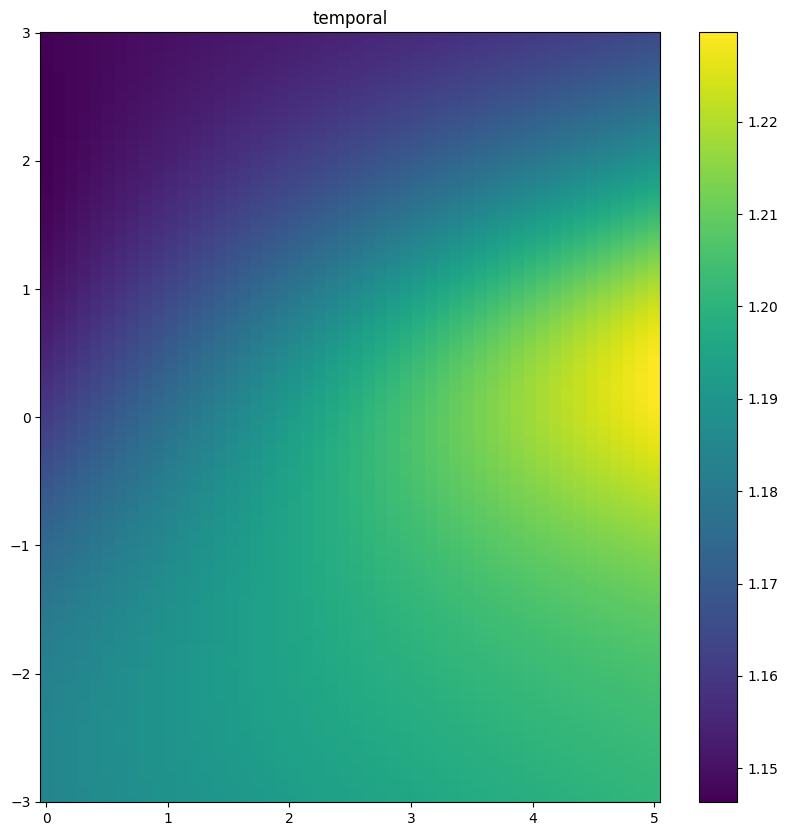

In [8]:
u_init = partial(u, u_params=init_nn_params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)

jinns.data.plot1d_image(u_init, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

## Model parameters

In [9]:
sigma = 0.5 * jnp.ones((1))
alpha = .5 * jnp.ones((1))
mu = jnp.zeros((1))

In our problem we know the analytical stationary solution

In [10]:
from jax.scipy.stats import norm

def u_statio(x):
    return norm.pdf(x, loc=0, scale=sigma/jnp.sqrt(2*alpha))[0] # output a scalar
vectorized_u_statio = vmap(u_statio, (0), 0)

A set of parameters as required by the losses' evaluate functions is a dictionary with the neural network parameters nn_params and the equation parameters eq_params. Here we construct this dictionary


In [11]:
init_params = {
    "nn_params":init_nn_params,
    "eq_params":{
        "sigma":sigma,
        "alpha":alpha,
        "mu":mu
    }
}

## Set up the initial condition

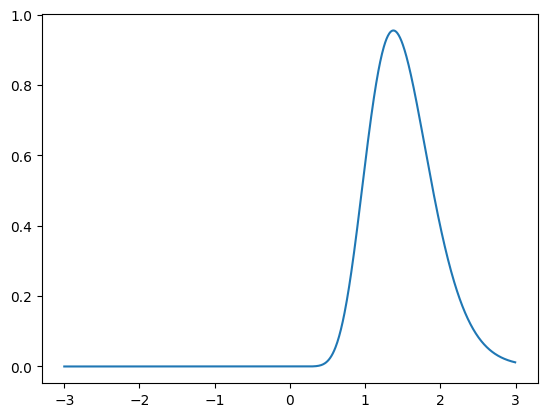

In [12]:
# Init to the stationary solution
#u0 = u_statio

# Another init
# # true solution N(0,1)
# sigma_init = 1 * jnp.ones((1))
# alpha_init = .25 * jnp.ones((1))
# mu_init = 2 * jnp.ones((1))
# @jit
# def u0(x):
#     return norm.pdf(x, loc=mu_init, scale=sigma_init/jnp.sqrt(2*alpha_init))[0] # output a scalar

# Yet another init
init_alphas = {"1": 1.5, "2": 1, "3": 0.5}

def u0(x):
    # Gamma pdf implemented in jax.scipy
    shape = (2 * init_alphas["1"]) / init_alphas["3"] ** 2
    scale =  init_alphas["3"] ** 2 / (2 * init_alphas["2"])
    return jax.scipy.stats.gamma.pdf(x, a = shape, scale = scale)[0]

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
#plt.title(r"Init condition $u_0$")

## Loss construction

We decide to provide the set of points upon which the normalization constant will be computed

In [13]:
int_xmin, int_xmax = -5, 5
n_samples = int(500)
int_length = int_xmax - int_xmin
key, subkey = random.split(key)
mc_samples = random.uniform(subkey, shape = (n_samples, 1), minval=int_xmin, maxval=int_xmax) 

In [14]:
OU_fpe_non_statio_1D_loss = jinns.loss.OU_FPENonStatioLoss1D(Tmax=Tmax)

In [15]:
loss_weights = {"dyn_loss":1, "norm_loss":0.001 * Tmax, "temporal_loss":0.1 * Tmax}

loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=OU_fpe_non_statio_1D_loss,
    temporal_boundary_fun=u0,
    norm_key=None,
    norm_borders=(int_xmin, int_xmax),
    norm_samples=mc_samples
)

/home/hugo/Documents/recherche/pinn/pinn_study/jinns/loss/_LossPDE.py:284: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [16]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
key, subkey = random.split(key)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch()
)


l_tot, d = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 9.37
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '8.29', 'norm_loss': '116.27', 'observations': '0.00', 'temporal_loss': '1.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [17]:
params = init_params

In [18]:
# Optimizer
import optax


tx = optax.adam(learning_rate=1e-3)

In [19]:
n_iter = int(20000)

In [20]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
)

Running for 20,000 iterations: 100%|████████████████| 20000/20000 [00:35<00:00, 564.70it/s]


## Results

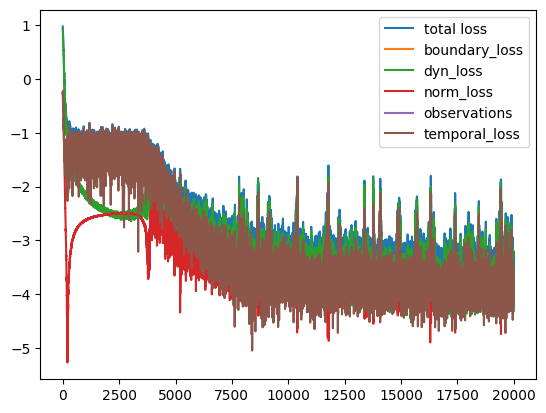

In [21]:
plt.plot(jnp.log10(total_loss_list), label="total loss")
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.legend()
plt.show();

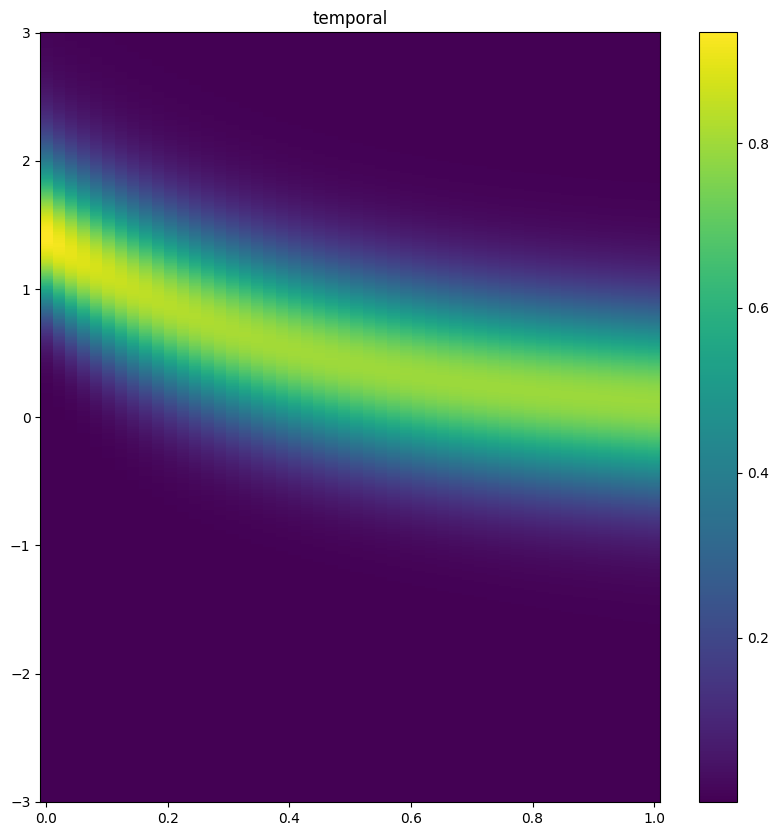

In [22]:
u_est = partial(u, u_params=params["nn_params"])

# same subkey
jinns.data.plot1d_image(u_est, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(10,10), title="temporal")

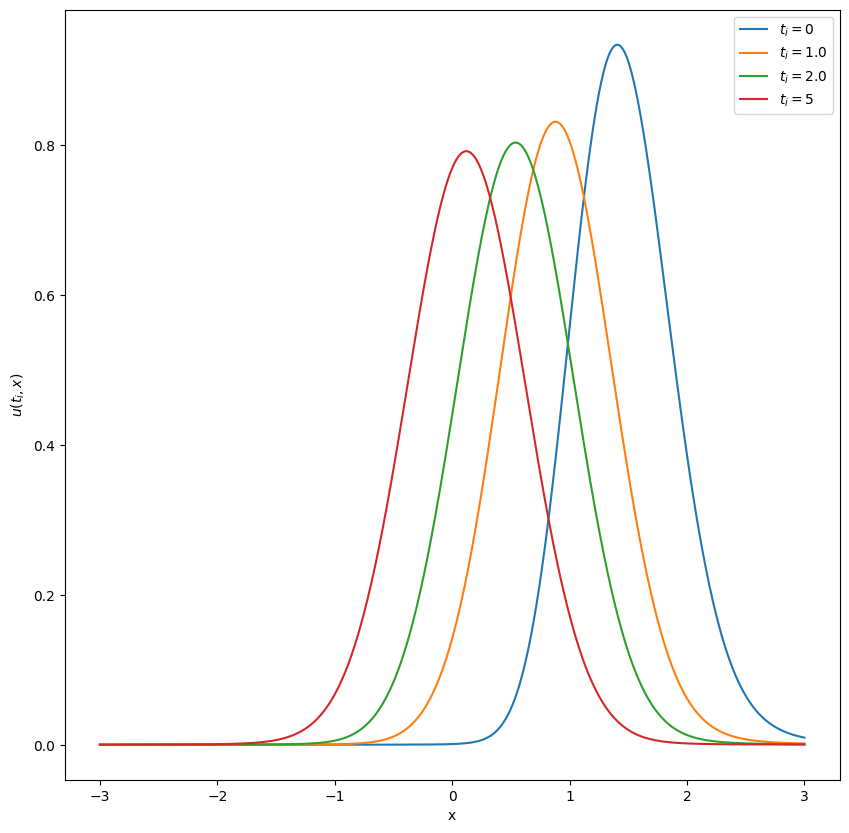

In [23]:
time_slices = [0, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax)

Note that the results for $t=25$ is wrong, hence the complexity for the network to extrapolate the solution to future times out of the training batch.

## Comparison with the true stationary solution

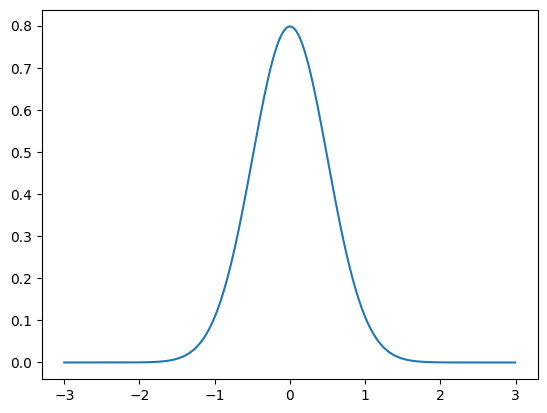

In [25]:
plt.plot(train_data.omega.sort(axis=0), vectorized_u_statio(train_data.omega.sort(axis=0)))
plt.show()

Save the estimated solution grid values

In [26]:
# x = test_data.omega.sort(axis=0).squeeze()
# t = test_data.times.sort(axis=0).squeeze()
# tv, xv = jnp.meshgrid(t, x)

# values = u_est_fp(tv.reshape((nt * n, 1)), xv.reshape((nt * n, 1)))
# grid = values.reshape(n, nt)
# jnp.save("OU_1D_nonstatio_solution_grid.npy",
#     jnp.stack(
#         [tv, xv, grid],
#         axis=-1
#     )
# )